In [1]:
from mlgrad.risk import ERisk, ERiskGB
from mlgrad.loss import SquareErrorLoss, ErrorLoss
from mlgrad.model import LinearFuncModel, SigmaNeuronModel, FFNetworkModel, \
                        FFNetworkFuncModel, SigmaNeuronModelLayer, LinearModel
from mlgrad.func import SoftPlus, Sqrt, Sigmoidal, HingeSqrt, Arctang, Absolute

from mlgrad import erm_fg, erm_irgd, fg, erm_fg, erisk
from mlgrad.regr import m_regression_irls
from mlgrad.af import averaging_function
from mlgrad.weights import MWeights

import numpy as np

In [2]:
import sklearn.datasets as datasets
import sklearn.metrics as metrics
import sklearn.preprocessing as preprocessing
import matplotlib.pyplot as plt

import sys
print(sys.version)

3.9.10 (main, Jan 16 2022, 17:12:18) 
[GCC 11.2.0]


In [3]:
# X, Y = datasets.load_boston(return_X_y=True)
# N = len(X)
# print(X.shape, X.dtype)
# print(Y.shape, Y.dtype)
# # print(Y)

In [4]:
from sklearn.datasets import fetch_california_housing
housing = fetch_california_housing()

In [5]:
X = housing.data
Y = housing.target

In [6]:
print(Y.shape, X.shape)
print(Y.dtype, X.dtype)

(20640,) (20640, 8)
float64 float64


In [7]:
X_o = preprocessing.scale(np.ascontiguousarray(X)) # preprocessing.robust_scale(X)
Y_o = Y.copy()

In [8]:
from mlgrad.boost.gb_regression import gb_fit, gb_fit_agg

In [9]:
# body = FFNetworkModel()
# layer = SigmaNeuronModelLayer(Sigmoidal(1.0), X.shape[1], 3)
# body.add(layer)
# head = LinearModel(3)
# mod = FFNetworkFuncModel(head, body)
# mod.allocate()
# mod = SigmaNeuronModel(Sigmoidal(1.0), X.shape[1])
# mod.init_param()

In [10]:
def new_model(N):
    mod = SigmaNeuronModel(Sigmoidal(1.0), N)
    mod.init_param()
    return mod

m = 10

lfm, lvals = gb_fit(X_o, Y_o, new_model, h=0.01, tol=1.0e-6, n_iter=m)
# print(np.asarray(lfm.weights))

In [11]:
alpha=0.96
lfm_agg, lvals_agg = gb_fit_agg(X_o, Y_o, new_model, alpha=alpha, h=0.01, tol=1.0e-6, n_iter=m)
# print(np.asarray(lfm_agg.weights))

In [12]:
print(np.asarray(lfm.weights))
print(np.asarray(lfm_agg.weights))

[ 4.07468227  1.12640375  0.26463031  1.47596475 -0.14375561  0.49194226
  0.55293064  0.27708238  0.11679984  0.37957875]
[4.33274838 0.39941592 0.38852601 0.60174508 1.03844342 0.68629907
 0.14485074 0.96086171 0.19644763 0.77393363]


The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


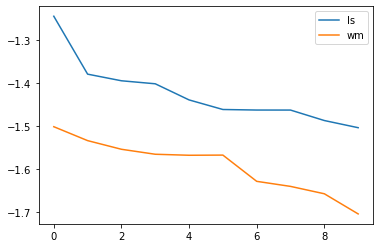

In [13]:
plt.plot(np.log(lvals), label='ls')
plt.plot(np.log(lvals_agg), label='wm')
plt.legend()
plt.savefig('calhousing_%.0f_lvals.eps' % (alpha*100,))
plt.show()

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


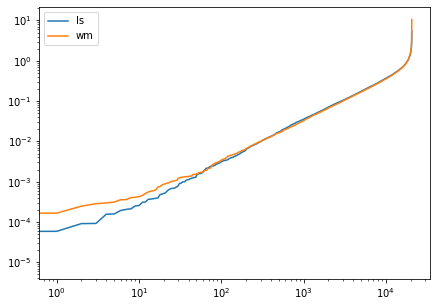

In [14]:
plt.figure(figsize=(7,5))
plt.loglog(sorted(np.abs(lfm.evaluate_all(X_o)-Y_o)), label='ls') #, marker='o', markersize=1)
plt.loglog(sorted(np.abs(lfm_agg.evaluate_all(X_o)-Y_o)), label='wm') #, marker='o', markersize=1)
plt.legend()
plt.savefig('cancer_%.0f_%s_errors.eps' % (alpha*100,m))
plt.show()

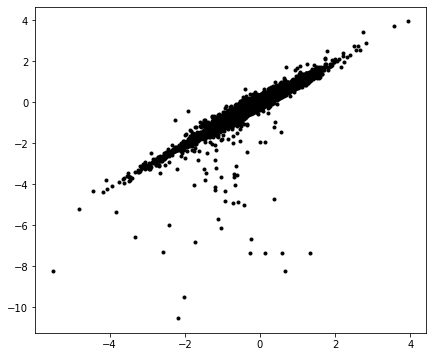

In [15]:
plt.figure(figsize=(7,6))
plt.scatter(lfm.evaluate_all(X_o)-Y_o, lfm_agg.evaluate_all(X_o)-Y_o, s=9, c='k')
plt.savefig('calhousing_%.0f_errors_box.eps' % (alpha*100,))
plt.show()

In [16]:
Y_ls = np.array([lfm(Xk) for Xk in X_o])
Y_agg = np.array([lfm_agg(Xk) for Xk in X_o])

In [17]:
err_ls = np.abs(Y_o - Y_ls)
err_wm = np.abs(Y_o - Y_agg)

acc_ls = metrics.mean_absolute_error(Y_o, Y_ls)
acc_wm = metrics.mean_absolute_error(Y_o, Y_agg)
var_ls = np.mean(np.abs(err_ls - acc_ls))
var_wm = np.mean(np.abs(err_wm - acc_wm))

print(acc_ls, acc_wm)
print(var_ls, var_wm)

0.4924954142310103 0.49458060716997954
0.3232124564820772 0.33476042027745784


In [18]:
err_ls = np.abs(Y_o - Y_ls)
err_wm = np.abs(Y_o - Y_agg)
acc_ls = np.median(err_ls)
acc_wm = np.median(err_wm)
var_ls = np.mean(np.abs(err_ls - acc_ls))
var_wm = np.mean(np.abs(err_wm - acc_wm))

print(acc_ls, acc_wm)
print(var_ls, var_wm)

0.37857343744219135 0.36857137588824934
0.3094440662669227 0.31785908314442124


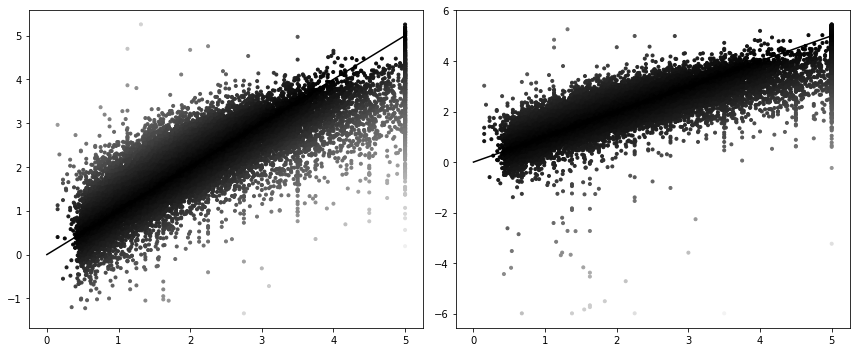

In [19]:
plt.figure(figsize=(12,5))
plt.subplot(1,2,1)
plt.scatter(Y_o, Y_ls, c=np.abs(Y_o-Y_ls), s=9, cmap=plt.cm.Greys_r)
plt.plot([0,5], [0,5], color='k')
plt.subplot(1,2,2)
plt.scatter(Y_o, Y_agg, c=np.abs(Y_o-Y_agg), s=9, cmap=plt.cm.Greys_r)
plt.plot([0,5], [0,5], color='k')
plt.subplot(1,2,2)
plt.tight_layout()
plt.show()